In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
sinfo=pd.read_csv("subject-info.csv")

In [60]:
ecg_data=pd.read_csv("test_measure.csv")
# remove values of RR too big
ecg_data = ecg_data[~((ecg_data['RR'] > 1000) & (ecg_data['power'] > 0))]
#df.drop(df['RR']>1000)

ecg_data


,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0
...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0
52058,18,947.816,528.0,0.507071,0
52059,18,948.344,528.0,0.507071,0
52060,18,948.884,540.0,0.507071,0


In [61]:
ecg_data_c = ecg_data.copy()

In [62]:
# remove RR values way above their surrounding value
ecg_data_c['RR_av'] = ecg_data_c.groupby('ID')['RR'].rolling(201).median().values
ecg_data_c = ecg_data_c[~((ecg_data_c['RR'] > ecg_data_c['RR_av']*2) | (ecg_data_c['RR'] < 0.5*ecg_data_c['RR_av']))]
ecg_data_c.drop(columns=['RR_av'], inplace=True)

ecg_data_c


,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0
...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0
52058,18,947.816,528.0,0.507071,0
52059,18,948.344,528.0,0.507071,0
52060,18,948.884,540.0,0.507071,0


In [85]:
# remove points increasing more than 10 time the normal surrounding increase
for i in range(15):
    print(i+1)
    ecg_data_c['diffRR'] = np.abs(ecg_data_c['RR'].diff())
    ecg_data_c['diffRR_av'] = ecg_data_c.groupby('ID')['diffRR'].rolling(201).median().values
    ecg_data_c['pb'] = (ecg_data_c['diffRR'] > 10*ecg_data_c['diffRR_av']) & (ecg_data_c['diffRR_av'] != 0)
    ecg_data_c['pb_before'] = ecg_data_c.groupby('ID')['pb'].shift(1)
    ecg_data_c.loc[(ecg_data_c['pb'] == 1) & (ecg_data_c['pb_before'] == 1), 'pb'] = 0
    print(ecg_data_c[ecg_data_c['pb'] == 1]['pb'].sum()/ecg_data_c.shape[0])
    ecg_data_c = ecg_data_c[ecg_data_c['pb'] == 0]
ecg_data_c

1
1.927636524856873e-05
2
1.927673683398874e-05
3
1.927710843373494e-05
4
1.927748004780815e-05
5
1.9277851676209204e-05
6
1.9278223318938927e-05
7
1.927859497599815e-05
8
1.92789666473877e-05
9
1.9279338333108406e-05
10
1.92797100331611e-05
11
1.928008174754661e-05
12
1.9280453476265763e-05
13
1.9280825219319387e-05
14
1.9281196976708315e-05
15
1.9281568748433373e-05


,ID,time,RR,VO2,power,diffRR,diffRR_av,pb,pb_before
0,1,-130.840,672.0,0.302008,0,NaN,NaN,False,NaN
1,1,-130.168,672.0,0.302008,0,0.0,NaN,False,False
2,1,-129.536,632.0,0.301336,0,40.0,NaN,False,False
3,1,-128.824,712.0,0.301336,0,80.0,NaN,False,False
4,1,-127.948,876.0,0.301336,0,164.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0,8.0,8.0,False,False
52058,18,947.816,528.0,0.507071,0,8.0,8.0,False,False
52059,18,948.344,528.0,0.507071,0,0.0,8.0,False,False
52060,18,948.884,540.0,0.507071,0,12.0,8.0,False,False


In [64]:
ecg_data_c.shape

(51877, 9)

In [65]:
ecg_data = ecg_data.merge(ecg_data_c[['ID', 'time']], how='left', on=['ID', 'time'])
ecg_data['remain']=None
ecg_data['remain'] = ecg_data['remain'].fillna(0)

In [66]:
ecg_data['remain'].nunique()

1

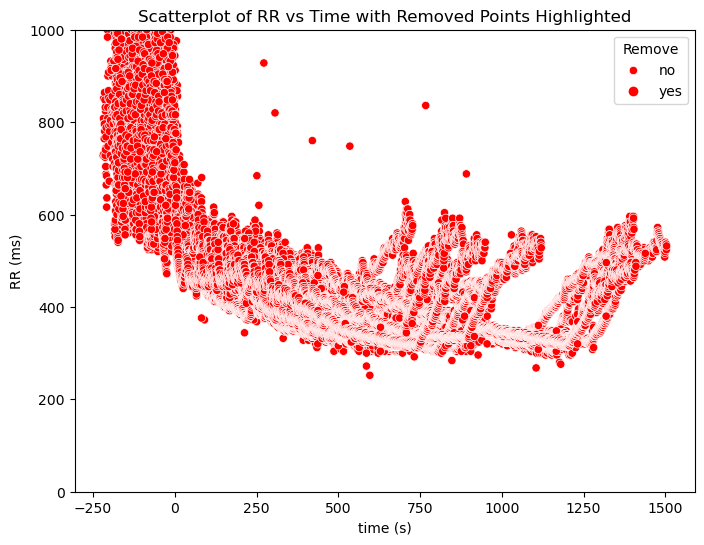

In [67]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ecg_data, x="time", y="RR", hue="remain",palette=["Red"])
plt.ylim(0, 1000)
plt.xlabel("time (s)")
plt.ylabel("RR (ms)")
plt.title("Scatterplot of RR vs Time with Removed Points Highlighted")
plt.legend(title="Remove", labels=["no", "yes"])
plt.show()

In [68]:
# Define test sequence
ecg_data['power_idx'] = (ecg_data.groupby('ID')['power']
                         .apply(lambda x: (x != x.shift()).cumsum()))
tmp = ecg_data.groupby('ID')['power_idx'].max().reset_index()
tmp = tmp.rename(columns={'power_idx': 'last_power_idx'})
ecg_data = ecg_data.merge(tmp, on='ID', how='left')
ecg_data['test']=None
ecg_data['test'] = np.select(
    [
        ecg_data['power_idx'] == 1,
        ecg_data['power_idx'] == ecg_data['last_power_idx']
    ],
    [
        'rest',
        'recovery'
    ],
   # default='test'
)


C:\Users\garin\AppData\Local\Temp\ipykernel_14488\1980378269.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: (x != x.shift()).cumsum()))


In [69]:
ecg_data.columns

Index(['ID', 'time', 'RR', 'VO2', 'power', 'remain', 'power_idx',
       'last_power_idx', 'test'],
      dtype='object')

In [70]:
ecg_data.shape

(52055, 9)

In [71]:
ecg_data.head()

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx,test
0,1,-130.840,672.0,0.302008,0,0,1,11,rest
1,1,-130.168,672.0,0.302008,0,0,1,11,rest
2,1,-129.536,632.0,0.301336,0,0,1,11,rest
3,1,-128.824,712.0,0.301336,0,0,1,11,rest
4,1,-127.948,876.0,0.301336,0,0,1,11,rest


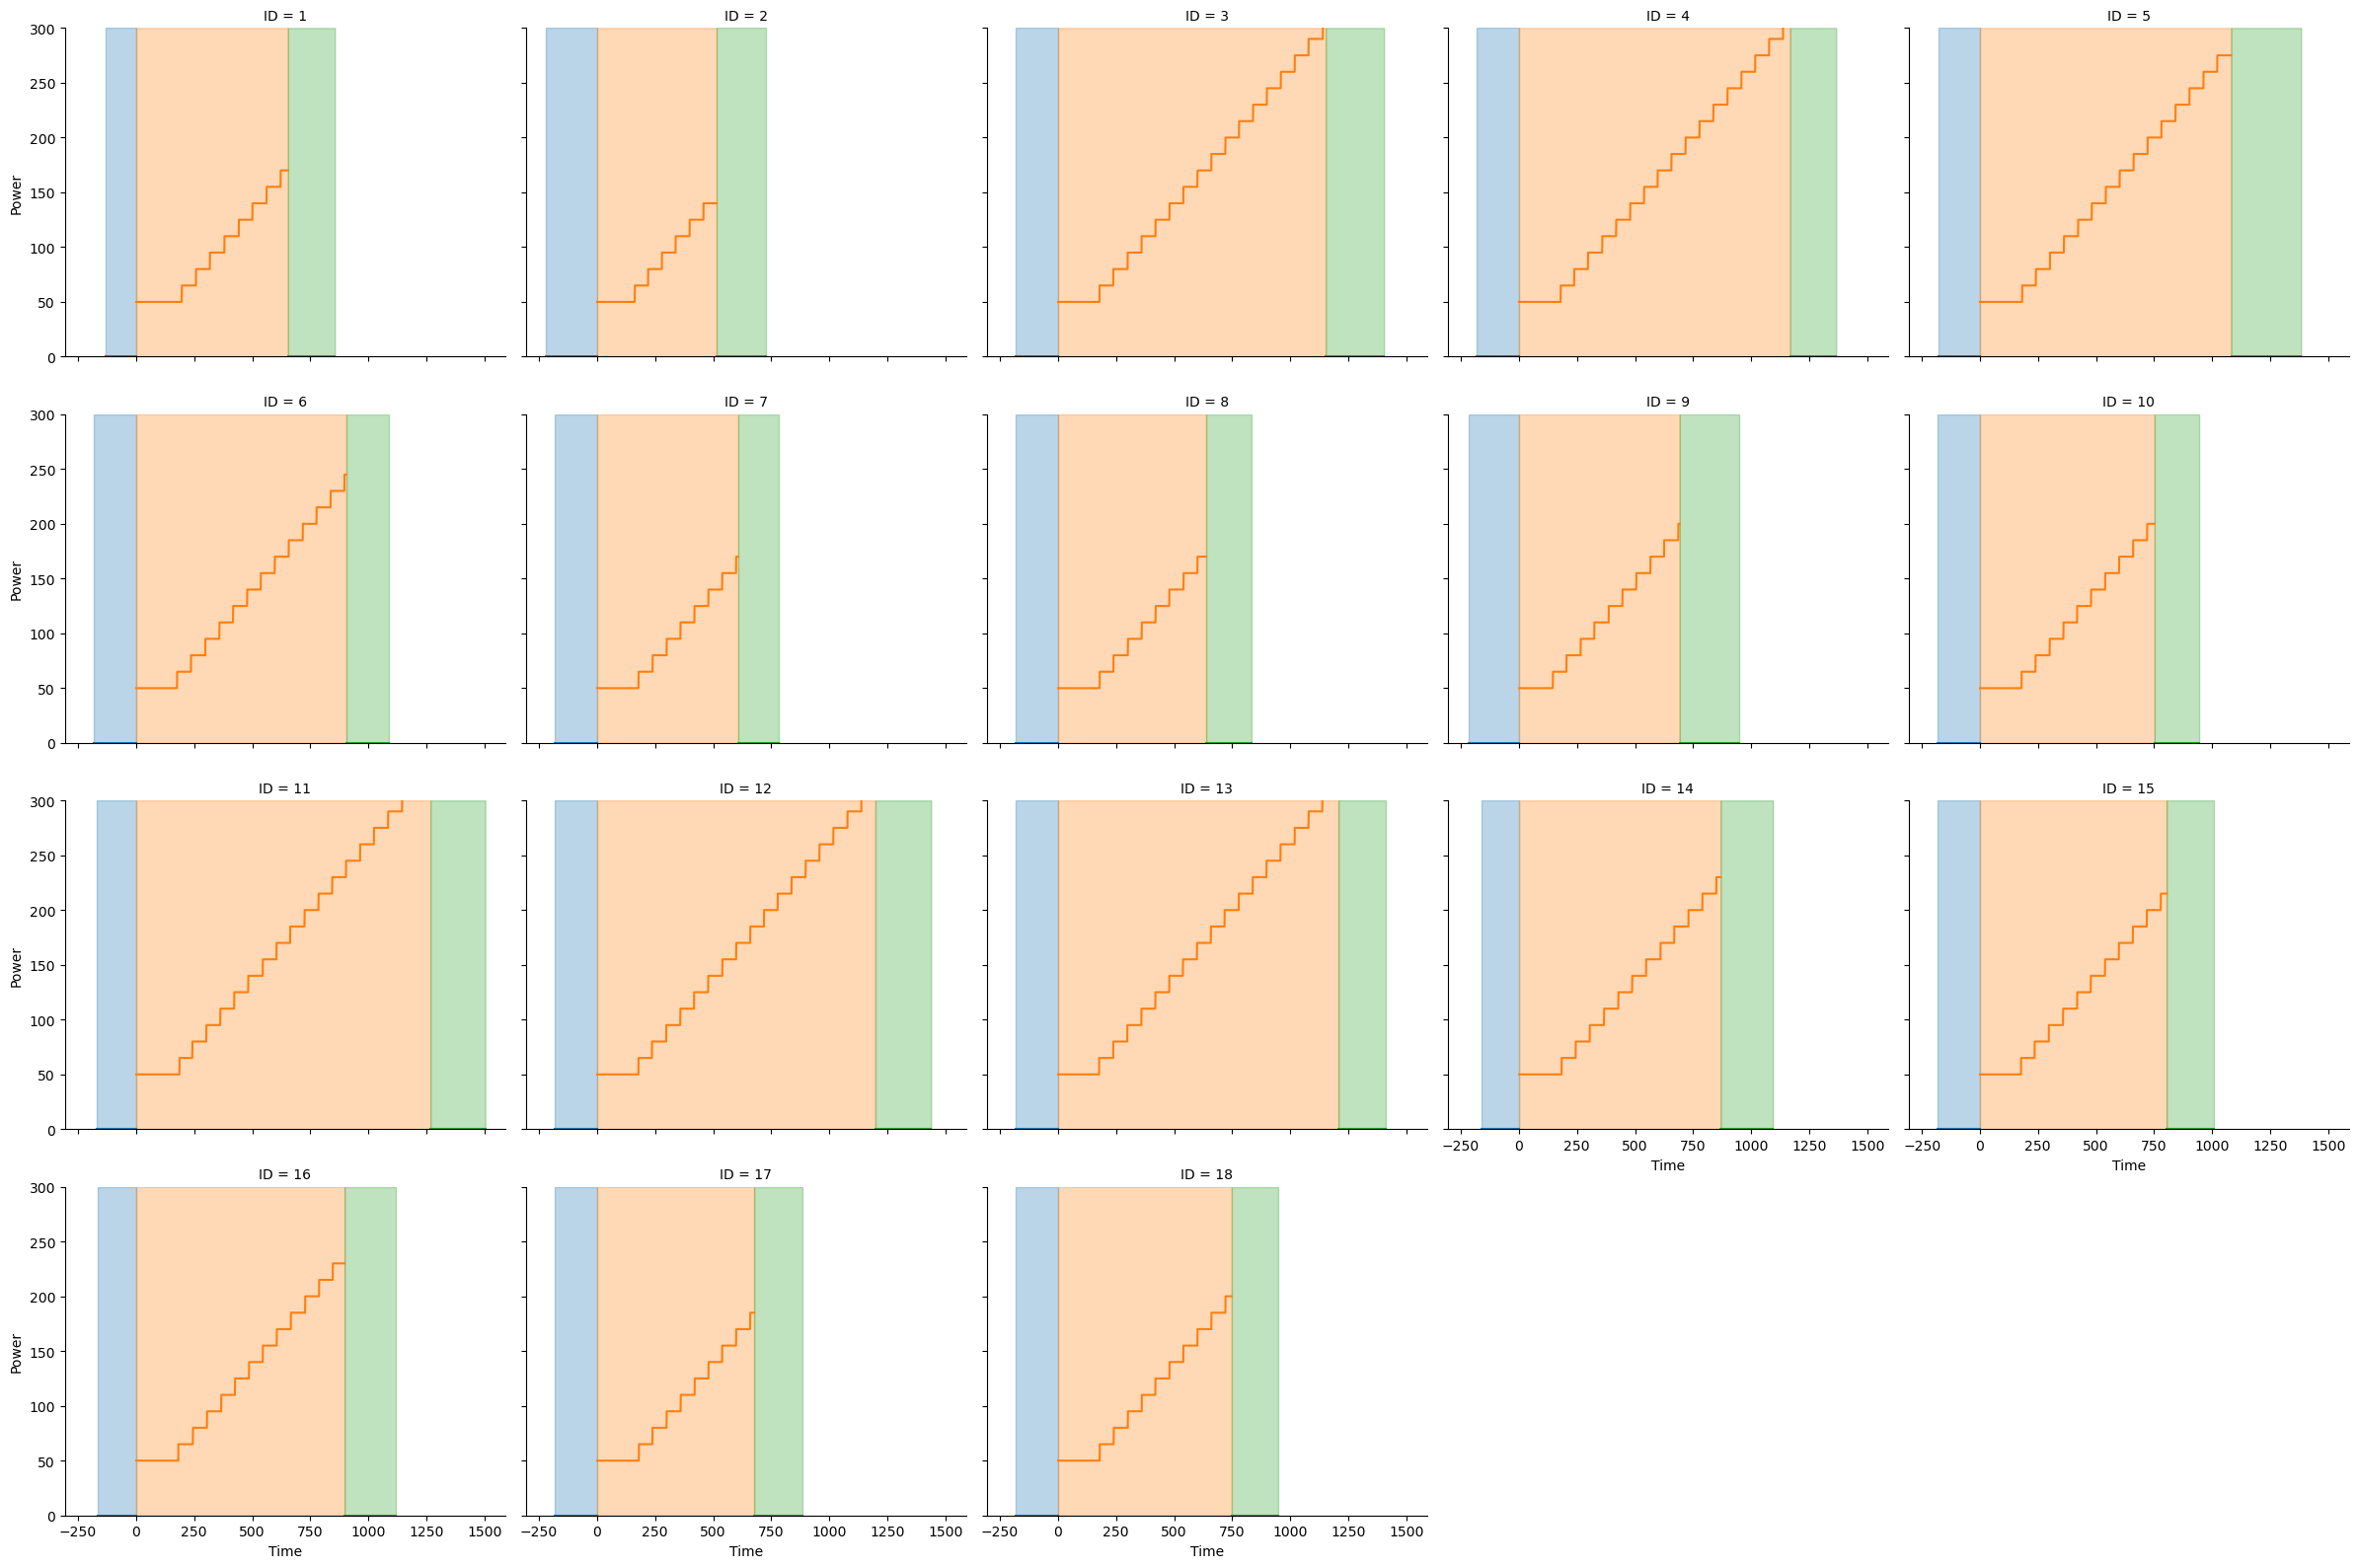

In [72]:
# Plot

g = sns.FacetGrid(data=ecg_data, col='ID', col_wrap=5, height=4, aspect=1.2,hue="test")
g = g.map(plt.plot, 'time', 'power')
g = g.map(plt.fill_between, 'time', y1=0, y2=300, alpha=0.3)
g = g.set_ylabels('Power')
g = g.set_xlabels('Time')
#g = g.add_legend()
plt.ylim(0, 300)
plt.show()

In [74]:
ecg_data['HR'] = 60000/ecg_data['RR']
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx,test,HR
0,1,-130.840,672.0,0.302008,0,0,1,11,rest,89.285714
1,1,-130.168,672.0,0.302008,0,0,1,11,rest,89.285714
2,1,-129.536,632.0,0.301336,0,0,1,11,rest,94.936709
3,1,-128.824,712.0,0.301336,0,0,1,11,rest,84.269663
4,1,-127.948,876.0,0.301336,0,0,1,11,rest,68.493151
...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,0,13,13,recovery,111.940299
52051,18,947.816,528.0,0.507071,0,0,13,13,recovery,113.636364
52052,18,948.344,528.0,0.507071,0,0,13,13,recovery,113.636364
52053,18,948.884,540.0,0.507071,0,0,13,13,recovery,111.111111


In [75]:
#To calculate HR rest and HR max, we need to group the data by ID and test sequence, and use the following formulas:

# calculate HR rest
hr_rest['HRrest']= ecg_data.groupby(['ID'])['HR'].mean()

hr_rest

ID
1                                                155.110805
2                                                139.277158
3                                                136.647228
4                                                149.006665
5                                                145.540187
6                                                136.729146
7                                                144.863255
8                                                 137.69714
9                                                153.356769
10                                               150.288667
11                                                139.52512
12                                               141.916278
13                                               143.114138
14                                                143.16124
15                                               144.940373
16                                                142.72215
17                                   

In [76]:
# calculate HR max and HRR
ecg_data['power_idx'] = (ecg_data['power'] != ecg_data['power'].shift()).cumsum()
max_data = ecg_data.groupby(['ID', 'power_idx']).agg(
    HRmax=('HR', 'max'),
    VO2max_abs=('VO2', 'max'),
    powermax=('power', 'max')
).groupby(['ID']).agg(
    HRmax=('HRmax', 'max'),
    VO2max_abs=('VO2max_abs', 'max'),
    powermax=('powermax', 'max')
)


max_data

,HRmax,VO2max_abs,powermax
ID,,,
1,197.368421,1.789775,170
2,197.368421,1.959791,140
3,182.926829,3.455253,305
4,223.880597,3.437170,305
5,189.873418,3.386349,275
6,202.702703,3.415759,245
7,238.095238,1.658511,170
8,200.000000,1.994151,170
9,200.000000,1.742767,200


In [77]:
sinfo['MaxHR']=220-sinfo['age']

In [78]:
df = pd.merge(sinfo, max_data, on='ID')

df

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR,HRmax,VO2max_abs,powermax
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200


In [79]:
df1=pd.merge(df,hr_rest,on='ID')

df1 = df1.rename(columns={'HR': 'HRrest'})
df1


,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR,HRmax,VO2max_abs,powermax,HRrest
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667


In [80]:
time_rest = ecg_data[ecg_data['test']=='recovery'].groupby(['ID']).first()['time']

In [81]:
df1=pd.merge(df1,time_rest,on='ID')

# VO2 Max calculation 1 : (VO2max*1000/W)

In [82]:
df1['Vo2inmL/Kg/min']=df1['VO2max_abs']*1000/df1['Weight']
df1


,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR,HRmax,VO2max_abs,powermax,HRrest,time,Vo2inmL/Kg/min
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,654.180,33.329152
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,514.980,34.871720
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,1153.336,38.434406
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,1168.112,44.930322
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,1082.308,44.323937
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,906.180,52.069497
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,608.028,33.303437
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,638.540,38.948254
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,692.240,30.521318
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,752.276,40.015518


# VO2 Max calculation 2 : (10.8*power/weight)+7)

In [83]:
df1['Vo2inmL/Kg/min/2']=(10.8*df1['powermax']/df1['Weight'])+7      
df1


,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR,HRmax,VO2max_abs,powermax,HRrest,time,Vo2inmL/Kg/min,Vo2inmL/Kg/min/2
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,654.180,33.329152,41.189944
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,514.980,34.871720,33.903915
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,1153.336,38.434406,43.640712
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,1168.112,44.930322,50.058824
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,1082.308,44.323937,45.874346
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,906.180,52.069497,47.335366
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,608.028,33.303437,43.867470
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,638.540,38.948254,42.859375
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,692.240,30.521318,44.828371
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,752.276,40.015518,43.734694


# ATHR - anaerobic threshold heart rate (ATHR)

In [84]:
df1['ATHR']=df1['MaxHR']*0.85
df1

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR,HRmax,VO2max_abs,powermax,HRrest,time,Vo2inmL/Kg/min,Vo2inmL/Kg/min/2,ATHR
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,654.180,33.329152,41.189944,174.25
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,514.980,34.871720,33.903915,174.25
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,1153.336,38.434406,43.640712,173.40
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,1168.112,44.930322,50.058824,173.40
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,1082.308,44.323937,45.874346,172.55
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,906.180,52.069497,47.335366,172.55
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,608.028,33.303437,43.867470,174.25
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,638.540,38.948254,42.859375,174.25
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,692.240,30.521318,44.828371,175.10
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,752.276,40.015518,43.734694,175.10


In [27]:
df1.to_csv("InsightsCrew_Cardiorespiratoryfitness_Cleanedreport.csv", index=False)

In [41]:
sinfo.to_csv("InsightsCrew_Cardiorespiratoryfitness_sinfo_Cleanedreport.csv", index=False)
sinfo

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR
0,1,15,53.7,161,50,140,fencing,205
1,2,15,56.2,162,80,127,fencing,205
2,3,16,89.9,191,155,300,fencing,204
3,4,16,76.5,180,215,275,fencing,204
4,5,17,76.4,186,110,172,fencing,203
5,6,17,65.6,169,131,186,fencing,203
6,7,15,49.8,165,65,108,fencing,205
7,8,15,51.2,165,80,133,fencing,205
8,9,14,57.1,176,50,125,fencing,206
9,10,14,58.8,177,101,162,fencing,206


# Exporting testmeasure cleaned data into new csv file 

In [ ]:
ecg_data_c.to_csv("InsightsCrew_Cardiorespiratoryfitness_Testmeasure1_Cleanedreport.csv", index=False)

In [35]:
Tm1=pd.read_csv("InsightsCrew_Cardiorespiratoryfitness_Testmeasure1_Cleanedreport.csv")

# Data cleaning where power !=0

In [36]:
Tm1=Tm1[Tm1.power != 0]

In [37]:
Tm1

,ID,time,RR,VO2,power,diffRR,diffRR_av,pb,pb_before
173,1,0.000,800.0,0.266493,50,84.0,NaN,False,False
174,1,0.912,912.0,0.266493,50,112.0,NaN,False,False
175,1,1.620,708.0,0.266493,50,204.0,NaN,False,False
176,1,2.276,656.0,0.246344,50,52.0,NaN,False,False
177,1,2.952,676.0,0.246344,50,20.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...
51414,18,746.412,316.0,1.795226,200,4.0,4.0,False,False
51415,18,746.732,320.0,1.597605,200,4.0,4.0,False,False
51416,18,747.048,316.0,1.597605,200,4.0,4.0,False,False
51417,18,747.368,320.0,1.597605,200,4.0,4.0,False,False


In [38]:
Tm1['VO2'] = round(Tm1['VO2'], 2)

In [91]:
Tm1['time'] = round(Tm1['time'], 2)
Tm1

,ID,time,RR,VO2,power,diffRR,diffRR_av,pb,pb_before
173,1,0.00,800.0,0.27,50,84.0,NaN,False,False
174,1,0.91,912.0,0.27,50,112.0,NaN,False,False
175,1,1.62,708.0,0.27,50,204.0,NaN,False,False
176,1,2.28,656.0,0.25,50,52.0,NaN,False,False
177,1,2.95,676.0,0.25,50,20.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...
51414,18,746.41,316.0,1.80,200,4.0,4.0,False,False
51415,18,746.73,320.0,1.60,200,4.0,4.0,False,False
51416,18,747.05,316.0,1.60,200,4.0,4.0,False,False
51417,18,747.37,320.0,1.60,200,4.0,4.0,False,False


In [102]:
Tm1=Tm1.drop(['pb','pb_before'],axis=1)
Tm1

KeyError: "['pb', 'pb_before'] not found in axis"

In [103]:
sf=pd.read_csv("InsightsCrew_Cardiorespiratoryfitness_Cleanedreport.csv")

In [104]:
sf

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR,HRmax,VO2max_abs,powermax,HR,time,Vo2inmL/Kg/min,Vo2inmL/Kg/min/2,ATHR
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,654.180,33.329152,41.189944,174.25
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,514.980,34.871720,33.903915,174.25
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,1153.336,38.434406,43.640712,173.40
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,1168.112,44.930322,50.058824,173.40
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,1082.308,44.323937,45.874346,172.55
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,906.180,52.069497,47.335366,172.55
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,608.028,33.303437,43.867470,174.25
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.697140,638.540,38.948254,42.859375,174.25
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,692.240,30.521318,44.828371,175.10
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,752.276,40.015518,43.734694,175.10


In [105]:
sf['HRmax'] = round(sf['HRmax'], 2)

In [106]:
sf

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR,HRmax,VO2max_abs,powermax,HR,time,Vo2inmL/Kg/min,Vo2inmL/Kg/min/2,ATHR
0,1,15,53.7,161,50,140,fencing,205,197.37,1.789775,170,155.110805,654.180,33.329152,41.189944,174.25
1,2,15,56.2,162,80,127,fencing,205,197.37,1.959791,140,139.277158,514.980,34.871720,33.903915,174.25
2,3,16,89.9,191,155,300,fencing,204,182.93,3.455253,305,136.647228,1153.336,38.434406,43.640712,173.40
3,4,16,76.5,180,215,275,fencing,204,223.88,3.437170,305,149.006665,1168.112,44.930322,50.058824,173.40
4,5,17,76.4,186,110,172,fencing,203,189.87,3.386349,275,145.540187,1082.308,44.323937,45.874346,172.55
5,6,17,65.6,169,131,186,fencing,203,202.70,3.415759,245,136.729146,906.180,52.069497,47.335366,172.55
6,7,15,49.8,165,65,108,fencing,205,238.10,1.658511,170,144.863255,608.028,33.303437,43.867470,174.25
7,8,15,51.2,165,80,133,fencing,205,200.00,1.994151,170,137.697140,638.540,38.948254,42.859375,174.25
8,9,14,57.1,176,50,125,fencing,206,200.00,1.742767,200,153.356769,692.240,30.521318,44.828371,175.10
9,10,14,58.8,177,101,162,fencing,206,192.31,2.352912,200,150.288667,752.276,40.015518,43.734694,175.10
